<table class="sprawko-header" style="width: 90%; border-style: hidden; font-size: 22px; line-height: 1.2em;">
<tr style="border-style: hidden;">
    <td style="width: 50%; border-style: hidden;">Informatyka, studia dzienne, II st.</td>
    <td style="width: 50%; text-align: right; border-style: hidden;">semestr II</td>
</tr>
<tr style="border-style: hidden;">
    <td style="width: 50%; border-style: hidden;">
        <b>Współczesne technologie programowania</b><br> Prowadzący: Kamil Stokfiszewski
    </td>
    <td style="width: 50%; text-align: right; border-style: hidden;">
        2016/2017<br> wtorek, 10:15
    </td>
</tr>
<tr style="border-style: hidden;">
    <td colspan="2">
        <ul style="width: 100%; text-align: center;  list-style: none;">
            <li>Daniel Pęczek 207585</li>
            <li>Michał Sośnicki 207597</li>
        </ul>
    </td>
</tr>
</table>

# Ćwiczenie 1: Analiza złożoności obliczeniowej i profilowanie algorytmów 

## Wprowadzenie
Zadanie polegało na stworzeniu programu sortującego tablicę liczb, zgodnie z algorytmem sortowania szybkiego i oszacowaniu na jego podstawie złożoności obliczeniowej tego algorytmu. Należy przy tym zwrócić uwagę na techniki pomiaru czasu i różnice między złożonością pesymistyczną, średnią i optymistyczną.

## Realizacja

Program sortujący liczby algorytmem `quicksort` zrealizowano w języku `C++`. Program ten sam generuje dane testowe o żądanym rozmiarze i mierzy oraz zwraca czas sortowania. Generując dane, potrafi spreparować na żądanie przypadek optymistyczny i pesymistyczny dla algorytmu sortowania szybkiego. Pomiar czasu odbywa się z wykorzystaniem funkcji `clock_gettimez` z parametrem `CLOCK_PROCESS_CPUTIME_ID`, która zwraca czas procesora wykorzystany przez proces, a nie ilość czasu, jaka upłynęła na zegarze.

Analizę czasu wykonywania i wykresy wykonano w środowisku `Jupyter` w języku `Python` z bibliotekami `numpy` oraz `matplotlib`. Skrypty pozyskują czas poprzez uruchamianie opisanego wcześniej programu sortującego, w sposób widoczny na poniższym bloku z kodem. `Jupyter` umożliwia wzbogacenie kodu o dobrze prezentujące się wizualnie bloki `markdown`, więc ta część rozwiązania stanowi zarazem sprawozdanie z zadania.

In [1]:
import numpy as np
import subprocess as sp

def run_get_stdout(name, *args):
    subprocess_args = [name] + list(map(str, args))
    return sp.run(subprocess_args, stdout=sp.PIPE).stdout

def run_quicksort(variant, reps, size, unique=0):
    times = map(float, run_get_stdout('../QuickSort/QuickSort', variant, reps, size, unique).split())
    return sum(times) / reps

apply_quicksort = np.vectorize(run_quicksort)

## Przypadek pesymistyczny

Sortowanie szybkie w przypadku pesymistycznym ma złożoność czasową $\Theta(n^2)$, gdzie $n$ to rozmiar sortowanego zestawu danych. W zaimplementowanej wersji algorytmu jako element, z którym porównywane są inne elementy (element osiowy, `pivot`), zawsze wybierany jest ostatni element z przedziału. Przypadkiem pesymistycznym dla takiego algorytmu jest sytuacja, w której zestaw danych wejściowych jest już posortowany malejąco lub rosnąco, gdyż wtedy jako element osiowy zawsze będzie wybierany element najmniejszy lub największy z przedziału. W takim wypadku jedno z rekurencyjnych wywołań `quicksort` będzie operować na przedziale tylko o jeden mniejszym. Liczba wywołań zależna liniowo od $n$ oraz rozmiar danych w każdym wywołaniu zależny liniowo od $n$ zaowocują kwadratową złożonością obliczeniową algorytmu. 

Właściwość ta jest bardzo niekorzystna, gdyż w części lub całości posortowane dane często spotykane są w praktyce. Można jednak zmodyfikować algorytm, by tę właściwość usunąć. Wybieranie elementu osiowego losowo sprawia, że posortowany zestaw danych przestaje być przypadkiem pesymistycznym, a trafienie na ten przypadek staje się nieprawdopodobne. Możliwe jest wybieranie na element osiowy mediany lub przybliżonej mediany przedziału, przy czym pierwszy przypadek gwarantuje złożoność liniowologarytmiczną algorytmu, lecz jest dość kosztowne. 

W przypadku pesymistycznym osiągana jest również najgorsza, liniową złożoność pamięciowa, gdyż każdy poziom rekursji zajmuje dodatkowo pewną stałą ilość pamięci, a to zagłębienie staje się w tym przypadku liniowo zależne od $n$. Jest to jednak do uniknięcia, jeżeli zastosuje się optymalizację polegającą na tym, iż rekurencyjne wywołanie sortowania zostanie wykonane najpierw dla krótszego przedziału, a później dla dłuższego. Wtedy, przy zastosowaniu dodatkowo optymalizacji rekursji ogonowej, złożoność pamięciowa w przypadku pesmistycznym jest stała, a zatem dla odmiany mniejsza niż w innych przypadkach. 

In [2]:
import functools as fn
import math
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd

def plot_times(data_sizes, running_times):
    plt.plot(data_sizes, running_times, 'o')
    plt.ylabel('Czas wykonywania [s]')
    plt.xlabel('Rozmiar sortowanej tablicy')
    plt.show()
    
def display_ratios(data_sizes, running_times):
    data_ratios = np.hstack([[math.nan], data_sizes[1:] / data_sizes[:-1]])
    time_ratios = np.hstack([[math.nan], running_times[1:] / running_times[:-1]])
    all_data = np.vstack([data_sizes, running_times, data_ratios, time_ratios]).T
    col_names = ['Data size', 'Running time', 'Data ratio', 'Time ratio']
    df = pd.DataFrame(all_data, columns=col_names)
    display(df)

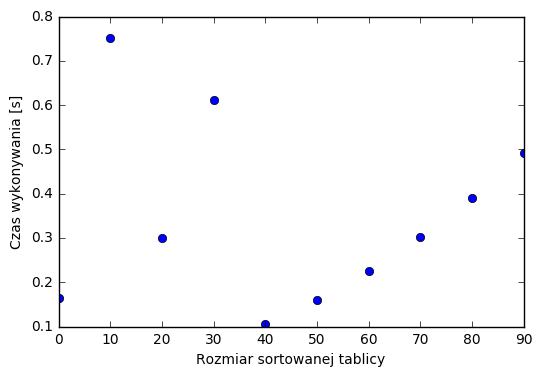

,Data size,Running time,Data ratio,Time ratio
0,200.0,0.243900,NaN,NaN
1,400.0,0.451398,2.0,1.850753
2,800.0,0.368323,2.0,0.815961
3,1600.0,0.141050,2.0,0.382951


In [3]:
apply_pessimistic = fn.partial(apply_quicksort, 'p')

data_sizes = np.arange(0, 100, 10)
running_times = apply_pessimistic(5, data_sizes)
plot_times(data_sizes, running_times)

data_sizes2 = np.exp2(np.arange(1, 5)) * 100
running_times2 = apply_pessimistic(5, data_sizes2)
display_ratios(data_sizes2, running_times2)

## Przypadek optymistyczny

W optymistycznym przypadku, sortowanie szybkie ma złożoność czasową $\Theta(n\ lg\ n)$. Jest to przypadek, gdy na każdym kroku sortowania za element osiowy (`pivot`) wybrana zostaje mediana przedziału i rekurencyjne wywołania algorytmu operują na podprzedziałach dwukrotnie krótszych lub prawie dwukrotnie, gdy długość jest nieparzysta.

Głebokość rekursji wynosi w takim przypadku $lg_2\ n$, przy czym na każdym poziomie głębokości przetworzonych zostaje $n$ elementów, a zatem ostatecznie liczba operacji zależy liniowologarytmicznie od rozmiaru sortowanego zestawu danych. Złożoność pamięciowa algorytmu zależy od głębokości rekursji, gdyż każde wywołanie wymaga zarezerwowania pewnej stałej ilości pamięci, i jest logarytmiczna.

W programie preparujemy dane do przypadku optymistycznego przez TODO

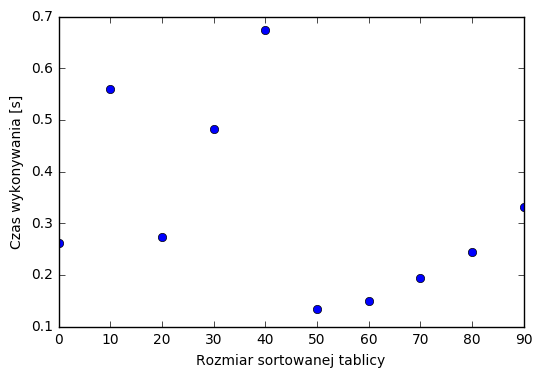

In [4]:
apply_optimistic = fn.partial(apply_quicksort, 'o')

data_sizes = np.arange(0, 100, 10)
running_times = apply_optimistic(5, data_sizes, 0)
plot_times(data_sizes, running_times)

## Przypadek średni

W średnim przypadku algorytm `quicksort` ma złożoność liniowologarytmiczną, podobnie jak w przypadku optymistycznym. Liczba operacji do wykonania jest zwykle relatywnie niewielka, czego skutkiem jest częste wykorzystanie tego algorytmu.

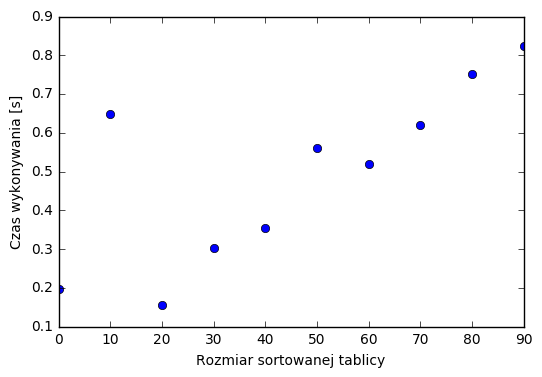

In [5]:
apply_average = fn.partial(apply_quicksort, 'r')

data_sizes = np.arange(0, 100, 10)
running_times = apply_average(5, data_sizes, 100)
plot_times(data_sizes, running_times)

Kwestią, na którą warto zwrócić uwagę, jest to jak szybkość działania algorytmu się zmienia, gdy w zestawie danych pojawia się dużo równych sobie elementów. Ustalenie, iż elementy równe elementowi osiowemu trafiają do jednego z podprzedziałów, które są rekurencyjnie sortowane, może sprawić, iż liczba operacji do wykonania wzrośnie wraz ze spadkiem liczby klas elementów. W szczególności jeżeli wszystkie elementy są sobie równe, to będziemy mieć do czynienia z przypadkiem pesymistycznym, gdyż $n - 1$ elementów trafi do prawego lub lewego podprzedziału.

Usunięcie tej cechy wymaga szczególnego traktowania elementów równych elementowi osiowemu. Jednym pomysłem może być umieszczanie ich na zmianę w lewym lub prawym podprzedziale. Alternatywnie można w trakcie dokonywania podziału umieścić wszystkie te elementy jeden po drugim obok elementu osiowego i rekurencyjnie dzielić tylko podprzedziały na lewo i na prawo od nich, ignorując je zupełnie, gdyż są już na swoim miejscu. Rozwiązanie to nadaje algorytmowi ciekawą cechę, iż jeżeli w zestawie danych jest $k$ klas elementów, to operacja podziału zostanie wykonana najwyżej $k$ razy. Jest to ogromnie korzystne, gdy $k$ jest małe, lecz odbywa się kosztem bardziej złożonej funkcji podziału. W wykonanym programie użyty został wariant TODO.  

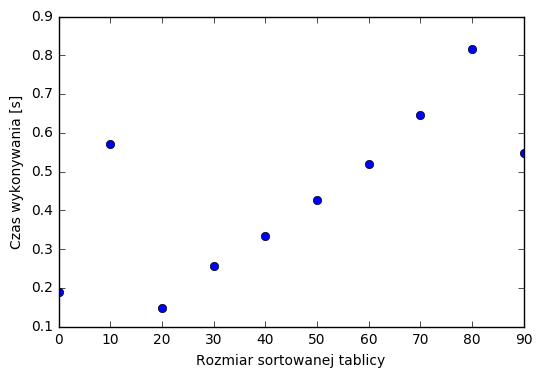

In [6]:
data_sizes = np.arange(0, 100, 10)
running_times = apply_average(5, data_sizes, 2)
plot_times(data_sizes, running_times)